In [5]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier 
from sklearn.metrics import f1_score, confusion_matrix, classification_report

# ЗАВАНТАЖЕННЯ ДАНИХ
df = pd.read_csv('hackathon_int20h_dataset_test.csv')
# ПЕРЕТВОРЕННЯ ДАТИ
df['created_at'] = pd.to_datetime(df['created_at'])
df['processed_at'] = pd.to_datetime(df['processed_at'])



In [6]:
#Первинна діагностика
print("--- Розмірність датасету ---")
print(df.shape) 

print("\n--- Типи даних та пропуски ---")
print(df.info()) 

print("\n--- Перші 5 записів ---")
print(df.head())

--- Розмірність датасету ---
(1000000, 18)

--- Типи даних та пропуски ---
<class 'pandas.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 18 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   created_at          1000000 non-null  datetime64[us]
 1   order_id            1000000 non-null  int64         
 2   processed_at        1000000 non-null  datetime64[us]
 3   order_type          1000000 non-null  str           
 4   user_id             1000000 non-null  int64         
 5   ip_country          1000000 non-null  str           
 6   currency            1000000 non-null  str           
 7   amount              1000000 non-null  float64       
 8   payment_method      1000000 non-null  str           
 9   order_payment_type  599474 non-null   str           
 10  bin_country         1000000 non-null  str           
 11  bank_id             1000000 non-null  int64         
 12  psp_id 


Статистика статусів:
status
success    525114
fail       474886
Name: count, dtype: int64


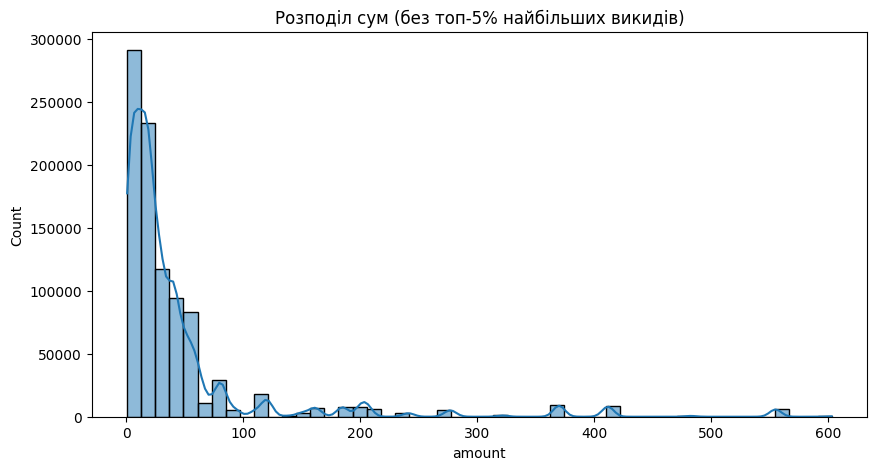


Топ-10 кодів помилок:
error_code
3.02    150121
3.08     90293
3.10     76797
2.12     44700
2.01     43696
3.04     42896
4.09     17647
4.03      1520
3.01      1468
0.01      1468
Name: count, dtype: int64


In [7]:

#  Аналіз статусів та помилок
# Аномалії часто корелюють зі статусом 'fail' 
print("\nСтатистика статусів:")
print(df['status'].value_counts())

#  Розподіл сум транзакцій (amount)
# Шукаємо "викиди" (дуже великі суми) 
plt.figure(figsize=(10, 5))
sns.histplot(df[df['amount'] < df['amount'].quantile(0.95)]['amount'], bins=50, kde=True)
plt.title('Розподіл сум (без топ-5% найбільших викидів)')
plt.show()

#  Кореляція помилок та аномалій
# Дивимося, які error_code виникають найчастіше 
top_errors = df['error_code'].value_counts().head(10)
print("\nТоп-10 кодів помилок:")
print(top_errors)


In [8]:
# Пошук аномалій
#  Різниця в країнах (IP vs Bank)
df['country_mismatch'] = (df['ip_country'] != df['bin_country']).astype(int)

# Час обробки в секундах
df['processing_duration'] = (df['processed_at'] - df['created_at']).dt.total_seconds()

# 3. Чи є сума повернення аномальною (наприклад, більше початкової суми)
df['excessive_refund'] = (df['refunded_amount'] > df['amount']).astype(int)

#  Нічні транзакції (наприклад, з 00:00 до 05:00)
df['hour'] = df['created_at'].dt.hour
df['is_night'] = df['hour'].apply(lambda x: 1 if x < 5 else 0)

#  Чи є транзакція високою (наприклад, сума більше 1000)
df['is_high_amount'] = (df['amount'] > 1000).astype(int)

# Кількість транзакцій одного користувача 
df['user_txn_count'] = df.groupby('user_id')['order_id'].transform('count')

# Середня сума транзакції для конкретного банку
df['bank_avg_amount'] = df.groupby('bank_id')['amount'].transform('mean')

# Чи є це перша покупка (з опису: order_type = first) 
df['is_first_order'] = (df['order_type'] == 'first').astype(int)

#  Чи є це повторна покупка (з опису: order_type = recurring)
df['is_recurring'] = (df['order_type'] == 'recurring').astype(int)

#  Безпека: Відсутність 3D-Secure (один із найсильніших маркерів фроду)
# В описі датасету вказано поле is_secured [cite: 51]
df['is_not_secured'] = (df['is_secured'] == False).astype(int)

#  Наявність технічної помилки
# Успішні транзакції зазвичай не мають error_code, його наявність при fail - це сигнал [cite: 56, 57]
df['has_error'] = df['error_code'].notna().astype(int)

#  Тип ініціації платежу: Швидка оплата (1-click)
# Фродери часто використовують збережені картки для швидких оплат [cite: 42, 43]
df['is_1click'] = (df['order_payment_type'] == '1-click').astype(int)

#  Відношення суми повернення до суми транзакції (Refund Ratio)
# Допомагає виявити часткові або підозрілі повернення, уникаючи проблеми різних валют [cite: 32, 36]
df['refund_ratio'] = df['refunded_amount'] / df['amount']
df['refund_ratio'] = df['refund_ratio'].fillna(0) # Заповнюємо нулями там, де не було повернення

#  Явний прапор наявності повернення (з опису) [cite: 34]
df['has_refund_flag'] = df['has_refund'].astype(int)





In [9]:
# ---  ПІДГОТОВКА ДАНИХ ДЛЯ МОДЕЛІ ---

from sklearn.preprocessing import LabelEncoder

# 1. Визначаємо текстові (категоріальні) колонки, які є в датасеті [cite: 33, 38, 54]
categorical_cols = [
    'currency', 
    'payment_method', 
    'order_type', 
    'order_payment_type', 
    'status', 
    'ip_country', 
    'bin_country',
    'psp_id' # Хоч це і ID, він може бути рядком, і для моделі це категорія [cite: 24]
]

# 2. Перетворюємо текст на числа за допомогою LabelEncoder
# Важливо: ініціалізуємо окремий енкодер для кожної колонки, якщо раптом знадобиться розшифровка

label_encoders = {}
for col in categorical_cols:
    # Перевіряємо, чи є колонка в датасеті, щоб уникнути помилок
    if col in df.columns:
        le = LabelEncoder()
        # Заповнюємо пропуски словом 'Unknown' перед перетворенням
        df[col] = df[col].fillna('Unknown').astype(str)
        df[col + '_encoded'] = le.fit_transform(df[col])
        label_encoders[col] = le

# 3. Обробка пропусків у числових даних
# Наприклад, якщо refunded_amount порожній, значить повернення не було (ставимо 0) [cite: 36]
df['refunded_amount'] = df['refunded_amount'].fillna(0)
# Якщо є інші пропуски в числових створених нами фічах (наприклад, refund_ratio)
df.fillna(0, inplace=True) 

print("Категоріальні дані успішно закодовані!")

Категоріальні дані успішно закодовані!


In [12]:
from sklearn.ensemble import IsolationForest

# 1. Збираємо всі наші створені та закодовані фічі в один список
features = [
    'amount', 
    'processing_duration', 
    'country_mismatch', 
    'is_night', 
    'is_not_secured', 
    'user_txn_count', 
    'refund_ratio', 
    'has_error', 
    'is_1click', 
    'is_recurring',
    'currency_encoded', 
    'payment_method_encoded', 
    'status_encoded'
]

# Перевіряємо, чи всі фічі є в датасеті (щоб уникнути помилок)
features = [f for f in features if f in df.columns]

# 2. Готуємо фінальну матрицю X
X = df[features].fillna(0)

# 3. Ініціалізуємо та навчаємо модель
# contamination=0.015 означає, що ми очікуємо приблизно 1.5% прихованих аномалій
print("Навчаємо модель Isolation Forest... (це може зайняти хвилину-дві)")
model = IsolationForest(n_estimators=100, contamination=0.015, random_state=42)
df['anomaly_score'] = model.fit_predict(X)

# Перетворюємо результати моделі: -1 (аномалія) -> 1, 1 (норма) -> 0
df['is_anomaly_ml'] = df['anomaly_score'].apply(lambda x: 1 if x == -1 else 0)

# 4. ГІБРИДНА ЛОГІКА (ML + Бізнес-правила)
# Модель може щось пропустити, тому додаємо залізні правила з опису датасету
df['is_anomaly'] = df['is_anomaly_ml']

 #  Скидаємо розмітку до тієї, що зробила тільки ML-модель (Isolation Forest)
df['is_anomaly'] = df['is_anomaly_ml']

#  Залишаємо тільки 100% залізне правило щодо махінацій з поверненням
if 'excessive_refund' in df.columns:
    df.loc[df['excessive_refund'] == 1, 'is_anomaly'] = 1

# 3. Аналізуємо специфічні помилки (опціонально)
# Замість того, щоб брати всі 'fail', можна було б взяти тільки технічні помилки, 
# але поки що довіримося Isolation Forest.

print(f"✅ Тепер знайдено аномалій: {df['is_anomaly'].sum()} з {len(df)}")

# Оновлюємо файл submission
submission = df[['order_id', 'is_anomaly']]
submission.to_csv('submission_solidgate_fixed.csv', index=False)
print("🎯 Файл 'submission_solidgate_fixed.csv' оновлено!")

Навчаємо модель Isolation Forest... (це може зайняти хвилину-дві)
✅ Тепер знайдено аномалій: 17176 з 1000000
🎯 Файл 'submission_solidgate_fixed.csv' оновлено!


Генеруємо Графік 1...


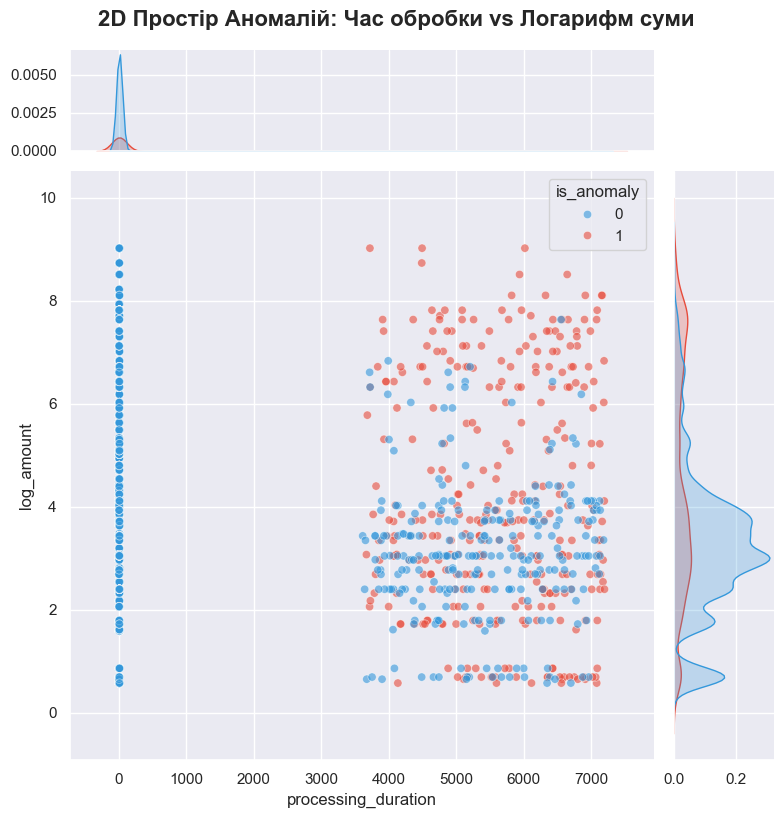

Генеруємо Графік 2...


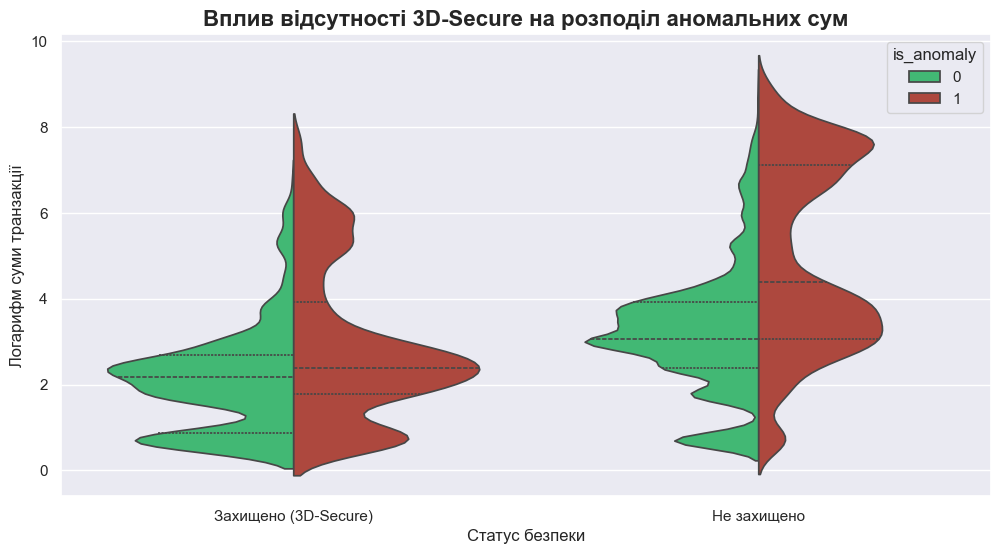

Генеруємо Графік 3...


C:\Users\HP\AppData\Local\Temp\ipykernel_13800\534387924.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette='magma')


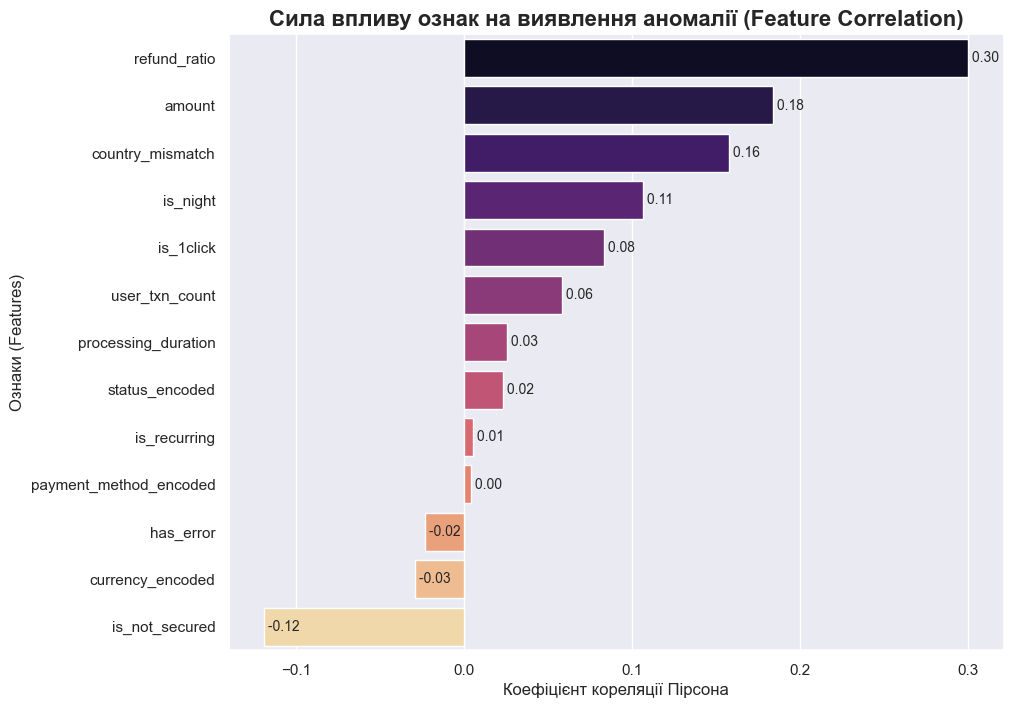

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Налаштовуємо крутий сучасний стиль для графіків
sns.set_theme(style="darkgrid", palette="deep")
plt.rcParams['figure.figsize'] = (12, 7)

# Оскільки 1 000 000 точок малювати довго, беремо репрезентативну вибірку
# Беремо всі аномалії та випадкові 50 000 нормальних транзакцій для чіткого контрасту
df_anomalies = df[df['is_anomaly'] == 1]
df_normal_sample = df[df['is_anomaly'] == 0].sample(n=min(50000, len(df[df['is_anomaly'] == 0])), random_state=42)
df_viz = pd.concat([df_anomalies, df_normal_sample])

# Логарифмуємо суму, щоб графіки не "ламалися" через гігантські викиди
df_viz['log_amount'] = np.log1p(df_viz['amount'])

# ==========================================
# ГРАФІК 1: JointPlot (Розподіл Сума vs Час обробки)
# ==========================================
print("Генеруємо Графік 1...")
g = sns.jointplot(
    data=df_viz, 
    x='processing_duration', 
    y='log_amount', 
    hue='is_anomaly', 
    palette={0: '#3498db', 1: '#e74c3c'}, # Синій - норма, Червоний - фрод
    alpha=0.6, 
    height=8,
    marginal_ticks=True
)
g.fig.suptitle('2D Простір Аномалій: Час обробки vs Логарифм суми', y=1.02, fontsize=16, fontweight='bold')
plt.show()

# ==========================================
# ГРАФІК 2: Violin Plot (Профіль безпеки)
# ==========================================
# Показує, як відсутність 3D-Secure впливає на аномалії при різних сумах
print("Генеруємо Графік 2...")
plt.figure(figsize=(12, 6))
sns.violinplot(
    data=df_viz, 
    x='is_not_secured', 
    y='log_amount', 
    hue='is_anomaly', 
    split=True, # Половинка скрипки - норма, половинка - аномалія
    inner="quart",
    palette={0: '#2ecc71', 1: '#c0392b'}
)
plt.title('Вплив відсутності 3D-Secure на розподіл аномальних сум', fontsize=16, fontweight='bold')
plt.xticks([0, 1], ['Захищено (3D-Secure)', 'Не захищено'])
plt.ylabel('Логарифм суми транзакції')
plt.xlabel('Статус безпеки')
plt.show()

# ==========================================
# ГРАФІК 3: Feature Importance (Кореляційний радар)
# ==========================================
# Що саме "видає" аномалію найбільше?
print("Генеруємо Графік 3...")
# Рахуємо кореляцію всіх фіч з колонкою is_anomaly
corr_with_target = df[features + ['is_anomaly']].corr()['is_anomaly'].drop('is_anomaly').sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette='magma')
plt.title('Сила впливу ознак на виявлення аномалії (Feature Correlation)', fontsize=16, fontweight='bold')
plt.xlabel('Коефіцієнт кореляції Пірсона')
plt.ylabel('Ознаки (Features)')

# Додаємо значення на графік для краси
for index, value in enumerate(corr_with_target.values):
    plt.text(value, index, f' {value:.2f}', va='center', fontsize=10)

plt.show()